## 1. Tehtävän ymmärtäminen ja tavoitteet

Olemme hyödyntäneet klusterointia ja assosiaatioanalyysiä löytääksemme sääntöjä, jotka voivat auttaa mielenterveyden ongelmien diagnosoinnissa ja itsemurhien ennaltaehkäisyssä. 

Työssä tutkitaan tilastoja itsemurhan tehneistä Yhdysvaltalaisnuorista koneoppimisen keinoin. Masennus, mielenterveysongelmat ja itsemurhat ovat vakava ja kasvava ongelma nyky-yhteiskunnassa. Työn motivaationa olisi löytää tilastoista trendejä jotka auttaisivat tunnistaa riskiryhmiä ja näiden trendien perusteella ehdottaa toimenpiteitä joilla nuoria voisi auttaa. Olemme hyödyntäneet klusterointia ja assosiaatioanalyysiä löytääksemme sääntöjä, jotka voivat auttaa mielenterveyden ongelmien diagnosoinnissa ja itsemurhien ennaltaehkäisyssä. 

### Tavoitteet:
- Löytää itsemurhatilastoista trendejä k-means klusteroinnin ja assosiaatioanalyysin avulla.
- Löytää mahdollisia ratkaisuja saatujen tulosten avulla.
- Löytää painopisteitä mihin resursseja on järkevintä suunnata jotta nuorten itsemurhia voidaan ennakoida ja ennaltaehkäistä.

## 2. Datan ymmärtäminen


Työssä käytetty tilasto on peräisin CDC:n(Yhdysvaltain tautikeskus) NVDRS-järjestelmästä. Tilastossa on kerätty tietoja 5-24 vuotiaista itsemurhan tehneistä nuorista. Data koostuu 72 muuttujasta + tunnisteesta ja sisältää 4000 riviä. Datassa on eritelty jokaiselle henkilölle tietoja mm. terveyshistoriasta, diagnooseista ja yksityiselämästä. Suurin osa muuttujista on binäärisinä arvoina (0=ei, 1=kyllä) ja osa taas kategorisina kuten esimerkiksi tarkemmat diagnoosit.

Datasetti sisältää 4000 riviä ja 73 saraketta, joista merkittävimpiä olivat:

- **MentalHealthProblem**: Henkilön mielenterveysongelmat
- **DepressedMood**: Masentunut mieliala
- **MentalIllnessTreatmentCurrent**: Tällä hetkellä saatu mielenterveyden hoito
- **HistoryMentalIllnessTreatment**: Aiempi mielenterveyden hoitohistoria
- **SuicideAttemptHistory**: Itsemurhayritysten historia
- **SuicideThoughtHistory**: Itsetuhoisten ajatusten historia

Data löytyy https://www.drivendata.org/competitions/296/cdc-novel-variables/



In [30]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('features_Z140Hep.csv')


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 73 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   uid                               4000 non-null   object
 1   NarrativeLE                       4000 non-null   object
 2   NarrativeCME                      4000 non-null   object
 3   LE_CircumstancesOtherText         453 non-null    object
 4   CME_CircumstancesOtherText        594 non-null    object
 5   MentalHealthProblem               4000 non-null   int64 
 6   DepressedMood                     4000 non-null   int64 
 7   MentalIllnessTreatmentCurrnt      4000 non-null   int64 
 8   HistoryMentalIllnessTreatmnt      4000 non-null   int64 
 9   SuicideAttemptHistory             4000 non-null   int64 
 10  SuicideThoughtHistory             4000 non-null   int64 
 11  AlcoholProblem                    4000 non-null   int64 
 12  SubstanceAbuseOther 

## 3. Datan esikäsittely 

### Datojen esikäsittely klusteroinnille

Ensimmäinen asia, johon kiinnitämme huomiota, on diagnooseja sisältävät sarakkeet. Niissä on tekstimuotoisia arvoja, jotka meidän täytyy muuntaa numeerisiksi jatkoanalyysiä varten. Käytämme tähän One-Hot -koodausta. Toimi seuraavasti:

- Eritä diagnoosisarakkeet erilliseen DataFrameen.
- Täytä puuttuvat arvot merkkijonolla 'Unknown', jotta vältät koodausvirheet.
- Koodaa diagnoosit käyttäen One-Hot -menetelmää.
- Yhdistä koodatut tiedot alkuperäisen DataFramen kanssa.
- Poista alkuperäiset diagnoosisarakkeet alkuperäisestä DataFramesta.

In [32]:
# Valitaan sarakkeet, jotka sisältävät diagnoosit
diagnosis_columns = [
    'LE_MentalHealthDiagnosis1', 
    'LE_MentalHealthDiagnosis2', 
    'LE_MentalHealthDiagnosisOther',
    'CME_MentalHealthDiagnosis1',
    'CME_MentalHealthDiagnosis2',
    'CME_MentalHealthDiagnosisOther'
]

# Käytä One-Hot-koodausta valittuihin sarakkeisiin
diagnosis_data = data[diagnosis_columns]

In [33]:
# Täytetään tyhjät kohdat tyhjillä riveillä koodausvirheiden välttämiseksi
diagnosis_data = diagnosis_data.fillna('Unknown')

In [34]:
# One-Hot-koodauksen käyttäminen
encoded_diagnosis_data = pd.get_dummies(diagnosis_data, prefix=diagnosis_columns)

In [35]:
# Yhdistetään koodatut tiedot alkuperäiseen datajoukoon
data_with_encoded_diagnosis = pd.concat([data, encoded_diagnosis_data], axis=1)

In [36]:
# Poistetaan vanhat sarakkeet, joissa on diagnoosit
data_with_encoded_diagnosis = data_with_encoded_diagnosis.drop(columns=diagnosis_columns)

data_with_encoded_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 388 entries, uid to CME_MentalHealthDiagnosisOther_Unstated mental health issues
dtypes: bool(321), int64(54), object(13)
memory usage: 3.3+ MB


Poistetaan seuraavaksi kaikki ei-numeraaliset piirteet klusterointia varten. Poistetaan myös piirteet, joiden nimessä on sanat "Unknown", "Unspecified" tai "Unstated", koska ne eivät sisällä informaatiota. Korvataan sitten boolen arvot 1:llä ja 0:lla.

In [37]:
# Suodatetaan vain numeeriset ominaisuudet klusterointia varten
data = data_with_encoded_diagnosis.select_dtypes(exclude='object')

# Poista kaikki sarakkeet, joiden nimessä on ”Unknown”, ”Unspecified” tai ”Unstated”, koska ne eivät sisällä vaikuttavia tietoja
keywords_to_remove = ['Unknown', 'Unspecified', 'Unstated', 'SuicideNote']
data = data.drop(columns=[col for col in data.columns if any(keyword in col for keyword in keywords_to_remove)])

# Korvataan Boolen arvot arvoilla 1 ja 0
df = data.apply(lambda x: x.map(lambda y: 1 if y == True else 0))

# Tarkistetaan mitä saattiin tuloksena
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 361 entries, MentalHealthProblem to CME_MentalHealthDiagnosisOther_Tourette syndrome
dtypes: int64(361)
memory usage: 11.0 MB


Tällä hetkellä datassa on 361 piirrettä. Sitten tarkistetaan korreloivatko piirteet keskenään ja poistetaan ne, jotka ovat korreloivia (> 0.8).

In [38]:
# Lasketaan korrelaatiomatriisi
corr_matrix = df.corr().abs()

# Valitaan matriisin yläkolmio
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Etsitään piirteet, joiden korrelaatio on > 0,8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Poistetaan voimakkaasti korreloivat piirteet
X_reduced = df.drop(columns=to_drop)

print(f"Piirteiden lukumäärä korreloivien piirteiden poistamisen jälkeen: {X_reduced.shape[1]}")

Piirteiden lukumäärä korreloivien piirteiden poistamisen jälkeen: 322


Tällä hetkellä datassa on 322 piirrettä.Se on liian paljon. Se voi johtaa ulottuvuuden kiroukseen. Ulottuvuuden kirous (curse of dimensionality) on keskeinen käsite koneoppimisessa ja datan analysoinnissa. Tässä sen tärkeimmät näkökohdat selitettynä:

1. **Datan harvuus**: Kun piirteiden määrä kasvaa, datan avaruus laajenee eksponentiaalisesti. Tämä johtaa tietojen harvuuteen; pisteet ovat yhä kauempana toisistaan. Korkeilla ulottuvuuksilla melkein jokainen piste on merkittävän matkan päässä muista pisteistä. Tämä vaikeuttaa samanlaisten objektien tunnistamista, mikä on erityisen tärkeää menetelmille kuten klusterointi tai k-lähimmät naapurit, joissa pisteiden läheisyys on avainkriteeri.

2. **Etäisyydet menettävät merkityksensä**: Korkeissa ulottuvuuksissa perinteiset etäisyysmittarit, kuten euklidinen etäisyys, menettävät informatiivisuutensa. Lopulta kaikki pisteet vaikuttavat olevan suunnilleen yhtä kaukana toisistaan. Tämä on kriittistä menetelmille, kuten K-means, jotka perustuvat etäisyyksien määrittämiseen klustereiden muodostamiseksi, koska klusterit muuttuvat epäselviksi ja huonosti määritellyiksi.

3. **Ylioppiminen (overfitting)**: Koneoppimisalgoritmit ovat alttiita ylioppimiselle, kun piirteitä on paljon. Ylioppiminen tapahtuu, kun malli mukautuu liikaa opetusdataan ja alkaa oppimaan kohinaa sen sijaan, että se tunnistaisi yleisiä säännönmukaisuuksia. Tämä on erityisen yleistä tilanteissa, joissa piirteitä on huomattavasti enemmän kuin havaintoja. Malli voi tällöin näyttää korkeata tarkkuutta opetusjoukossa, mutta heikkoa yleistettävyyttä uusilla tiedoilla.

Käytetään piirredevalintamenetelmää (`Feature Selection`), joka perustuu varianssiin (`Variance Threshold`). Tämä menetelmä mahdollistaa sellaisten piirteiden poissulkemisen, joilla on alhainen varianssi (toisin sanoen ne eivät muutu juuri lainkaan datassa). Tämä on yksinkertainen tapa vähentää piirteiden määrää luottamatta tavoitearvoihin.

In [39]:
from sklearn.feature_selection import VarianceThreshold

# Asetetaan minimivarianssin kynnys 0.08
selector = VarianceThreshold(threshold=0.08)

# Sovelletaan valitsijaa (selector) tietoihin
df_reduced = selector.fit_transform(X_reduced)

# Saadaan valittujen piirteiden maski
mask = selector.get_support()

# Suodataan alkuperäiset sarakeotsikot maskin perusteella
selected_columns = X_reduced.columns[mask]

# Luodaan uusi DataFrame valituilla piirteillä ja tallennetaan niiden nimet
df = pd.DataFrame(df_reduced, columns=selected_columns)

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype
---  ------                                           --------------  -----
 0   MentalHealthProblem                              4000 non-null   int64
 1   DepressedMood                                    4000 non-null   int64
 2   MentalIllnessTreatmentCurrnt                     4000 non-null   int64
 3   HistoryMentalIllnessTreatmnt                     4000 non-null   int64
 4   SuicideAttemptHistory                            4000 non-null   int64
 5   SuicideThoughtHistory                            4000 non-null   int64
 6   AlcoholProblem                                   4000 non-null   int64
 7   SubstanceAbuseOther                              4000 non-null   int64
 8   Argument                                         4000 non-null   int64
 9   IntimatePartnerProblem                           400

,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,AlcoholProblem,SubstanceAbuseOther,Argument,IntimatePartnerProblem,FamilyRelationship,SchoolProblem,SuicideIntentDisclosed,DisclosedToOtherFamilyMember,LE_MentalHealthDiagnosis1_Depression/dysthymia,CME_MentalHealthDiagnosis1_Depression/dysthymia
0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0
3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,1,1,1,0,1,0,0,0,0,0,1,0,0,1
3996,1,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0
3997,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0
3998,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


Lopulta, ennakkokäsittelyn jälkeen, saattiin datajoukko, jossa on 16 piirrettä. Nyt voidaan siirtya mallin rakentamiseen `k-means` menetelmällä.

### Datojen esikäsittely assosioitumiselle

Jotta voidaan analysoida assosioitumista, muutetaan datajoukko binäärimuotoon. Tämä tarkoittaa, että kaikki arvot muutetaan joko 0 tai 1. Tämä on tarpeen, koska `Apriori`-algorit käsittelee binäärimuotoista dataa.

In [40]:
df_association = df.apply(lambda x: x.map(lambda y: True if y == 1.0 else False))
df_association

,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,AlcoholProblem,SubstanceAbuseOther,Argument,IntimatePartnerProblem,FamilyRelationship,SchoolProblem,SuicideIntentDisclosed,DisclosedToOtherFamilyMember,LE_MentalHealthDiagnosis1_Depression/dysthymia,CME_MentalHealthDiagnosis1_Depression/dysthymia
0,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,True,True,False,False,False,True,True,False,False
3,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,True,False,True,True,True,False,True,False,False,False,False,False,True,False,False,True
3996,True,False,False,True,True,True,False,True,False,False,False,False,True,False,True,False
3997,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,False
3998,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False


## 4. Mallinnus

### Klusterointi

Tehdään klusterointia `K-means` -menetelmällä samankaltaisten potilaiden ryhmien löytämiseksi ja arvioimme piirteiden tärkeyttä jokaiselle ryhmälle.

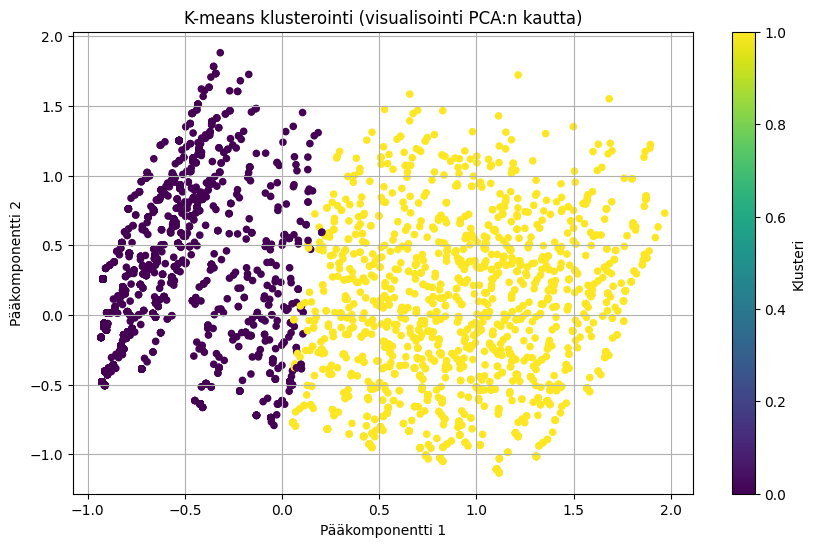

In [41]:
# K-means klusterointi
data = df.copy()
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(data)


# Sovelletaan PCA:ta (Pääkomponenttianalyysiä) ulottuvuuden vähentämiseksi 2D-tilaan visualisointia varten
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)


# Visualisointi
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', s=20)
plt.colorbar(scatter, label='Klusteri')
plt.title('K-means klusterointi (visualisointi PCA:n kautta)')
plt.xlabel('Pääkomponentti 1')
plt.ylabel('Pääkomponentti 2')
plt.grid(True)
plt.show()

# Lisätään klusterimerkit alkuperäiseen DataFrameen
data['Cluster'] = kmeans.labels_

In [42]:
df = data.copy()

## 5. Arviointi

### Klusterointi

Arvioidaan klusteroinnin onnistumista `WCSS`(`Elbow`-menetelmä) ja `Silhouette`-kertoimen avulla.

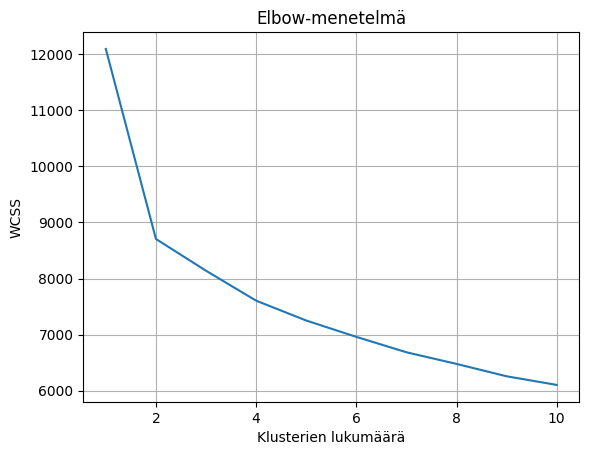

In [43]:
import matplotlib.pyplot as plt

df = df.copy()

wcss = []
for i in range(1, 11):  # Tarkistetaan 1-10 klusteria
   kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
   kmeans.fit_predict(df)
   wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Klusterien lukumäärä')
plt.ylabel('WCSS')
plt.title('Elbow-menetelmä')
plt.grid(True)
plt.show()

Tästä visualisoinnista nähdään, että optimaalinen klusterien määrä on 2. Seuraavaksi tarkistetaan `Silhouette`-kerroin.

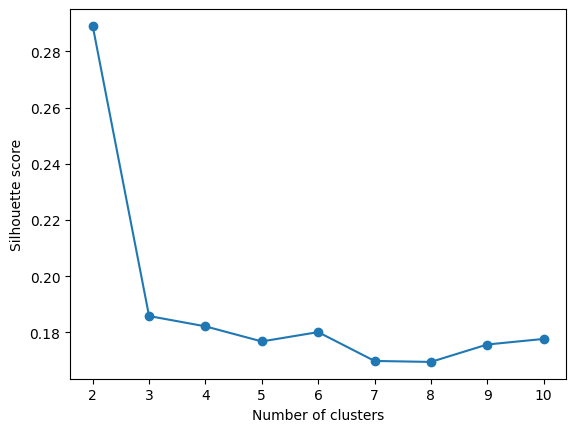

In [44]:
from sklearn.metrics import silhouette_score

df = df.copy()

silhouette_scores = []
for i in range(2, 11):
    model = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10).fit(df)
    labels = model.labels_
    silhouette_scores.append(silhouette_score(df, labels))
    
# Visualisoidaan Silhouette score

plt.plot(range(2, 11), silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

`Silhouette`-arvo on korkein, kun klustereiden määrä on 2. Tämä vahvistaa aiemman `Elbow`-menetelmän tuloksen. Seuraavaksi tarkastellaan klustereita ja niiden ominaisuuksia.

In [45]:
df = df.copy()

# Muuttujat tulosten tallentamiseen
silhouette_scores = []
k_values = list(range(2, 11))

# Klustereiden määrän läpikäynti
for n_clusters in k_values:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, clusters)
    silhouette_scores.append(silhouette_avg)
    print(f"Klustereiden määrä: {n_clusters}, Silhouette-kerroin: {silhouette_avg:.2f}")

Klustereiden määrä: 2, Silhouette-kerroin: 0.29
Klustereiden määrä: 3, Silhouette-kerroin: 0.24
Klustereiden määrä: 4, Silhouette-kerroin: 0.23
Klustereiden määrä: 5, Silhouette-kerroin: 0.18
Klustereiden määrä: 6, Silhouette-kerroin: 0.18
Klustereiden määrä: 7, Silhouette-kerroin: 0.18
Klustereiden määrä: 8, Silhouette-kerroin: 0.18
Klustereiden määrä: 9, Silhouette-kerroin: 0.18
Klustereiden määrä: 10, Silhouette-kerroin: 0.18


`Silhouette`-kerroin vaihdelee välillä -1 ja 1. Lähellä 1 oleva arvo osoittaa, että havainnot ovat hyvin klusteroidut ja kaukana muista klustereista. Lähellä -1 oleva arvo osoittaa, että havainnot ovat väärässä klusterissa. Arvo 0 tarkoittaa, että klusterit ovat päällekkäisiä. Tässä tapauksessa silhouettikerroin on noin 0,29 mitä osoittaa, että klusterit eroavat toisistaan mutta ei niin hyvin. 

Tehdään klustereiden analyysi ja yritetään tehdä johtopäätöksiä jokaisesta niistä

In [46]:
# Lasketaan ominaisuuksien keskiarvot kullekin klusterille
cluster_means = df.groupby('Cluster').mean()

# Kustakin klusterista etsitään ominaisuudet, joiden keskiarvot ovat suurimmat
for cluster in cluster_means.index:
    print(f"\nKluster {cluster}:")
    # Etsetään 10 ominaisuutta, joilla on korkeimmat arvot tietyssä klusterissa
    top_features = cluster_means.loc[cluster].sort_values(ascending=False).head(10)
    print(top_features)




Kluster 0:
DepressedMood             0.290004
IntimatePartnerProblem    0.278421
SuicideThoughtHistory     0.275847
SuicideIntentDisclosed    0.226083
Argument                  0.225654
FamilyRelationship        0.147576
SubstanceAbuseOther       0.145431
MentalHealthProblem       0.126555
SchoolProblem             0.095667
SuicideAttemptHistory     0.092664
Name: 0, dtype: float64

Kluster 1:
MentalHealthProblem                                0.991013
HistoryMentalIllnessTreatmnt                       0.838826
MentalIllnessTreatmentCurrnt                       0.613541
CME_MentalHealthDiagnosis1_Depression/dysthymia    0.608149
SuicideThoughtHistory                              0.596165
LE_MentalHealthDiagnosis1_Depression/dysthymia     0.451168
DepressedMood                                      0.381067
SuicideAttemptHistory                              0.372678
SuicideIntentDisclosed                             0.341522
IntimatePartnerProblem                             0.281606
Na

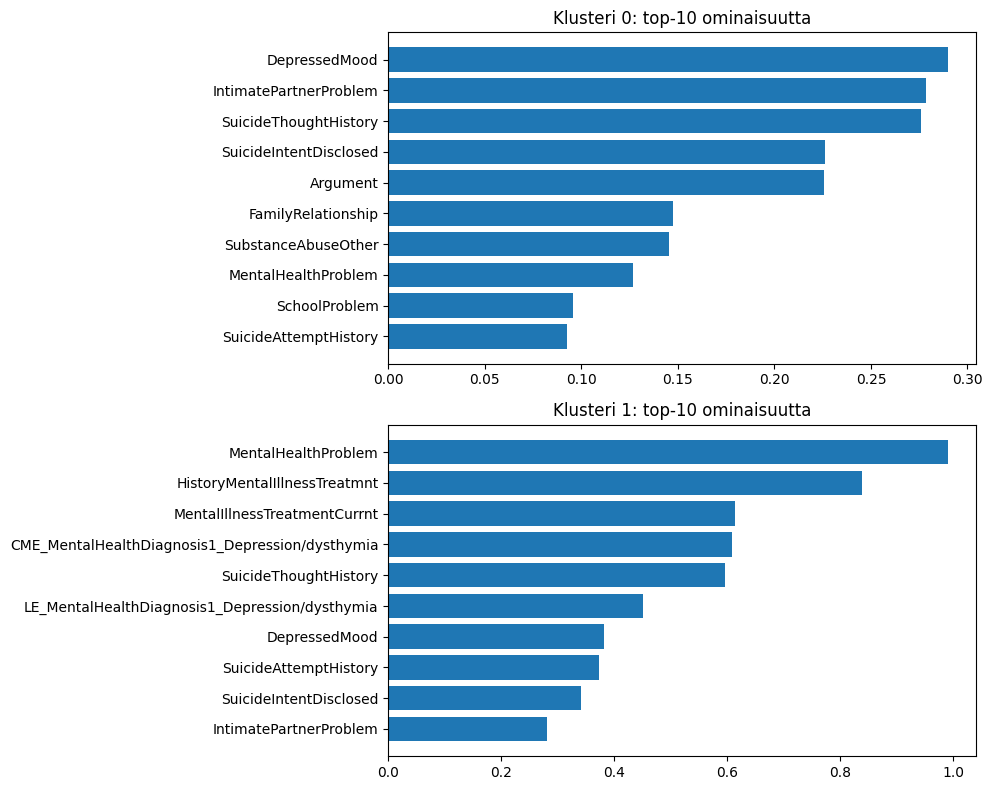

In [47]:
# Visualisoimme 10 ominaisuutta, joilla on korkeimmat painearvot kussakin klusterissa
fig, axs = plt.subplots(len(cluster_means.index), figsize=(10, 8))

for idx, cluster in enumerate(cluster_means.index):
    top_features = cluster_means.loc[cluster].sort_values(ascending=False).head(10)
    
    axs[idx].barh(top_features.index, top_features.values)
    axs[idx].set_title(f'Klusteri {cluster}: top-10 ominaisuutta')
    axs[idx].invert_yaxis()

plt.tight_layout()
plt.show()

### Klusterianalyysi ja johtopäätökset


#### Klusteri 0:

**Tärkeimmät ominaisuudet:**
1. **DepressedMood (masentunut mieliala)** — 28,88 %
2. **IntimatePartnerProblem (ongelmat läheisissä ihmissuhteissa)** — 27,93 %
3. **SuicideThoughtHistory (itsemurha-ajatusten historia)** — 27,71 %
4. **Argument (riidat, konfliktit)** — 22,77 %
5. **SuicideIntentDisclosed (itsemurha-aikeiden ilmaiseminen)** — 22,68 %


#### Klusteri 1:

**Tärkeimmät ominaisuudet:**
1. **MentalHealthProblem (mielenterveysongelmat)** — 99,16 %
2. **HistoryMentalIllnessTreatmnt (aiempi mielenterveyshoito)** — 83,61 %
3. **MentalIllnessTreatmentCurrnt (nykyinen mielenterveyshoito)** — 61,18 %
4. **Depression/Dysthymia (masennus/dystymia-diagnoosi)** — noin 61 %
5. **SuicideThoughtHistory (itsemurha-ajatusten historia)** — 59,39 %


#### Johtopäätökset:
1. Klusterien kokoonpanosta päätellen on selvää, että itsemurhan tehneet jaetaan kahteen ryhmään. Yksi ryhmä on jo psykiatrien valvonnassa ja hoidossa olevat. Toinen ryhmä ovat ne, jotka eivät saa hoitoa ja joita ei seurata.
2. Itsemurhatapausten lisääntyminen valvonnassa olevien keskuudessa voi olla seurausta psykiatrien työstä ja epäsoveltuvasta hoidosta. Hoitoon jääneiden keskuudessa tapahtuneet itsemurhatapaukset ovat seurausta psykologien ja yhteiskunnan tason häiriöiden ehkäisyyn osallistuneiden riittämättömästä työstä.
3. Mielestämme huomion painopiste on suunnattava toiseen ryhmään, koska he eivät saa apua eivätkä ole valvonnan alaisia. Tämän ryhmän tunnistaminen ja auttaminen masennuksen ja muiden häiriöiden merkkien varalta voi vähentää itsemurhien määrää.

### Assosioituminen 

In [48]:
df_association

,MentalHealthProblem,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,AlcoholProblem,SubstanceAbuseOther,Argument,IntimatePartnerProblem,FamilyRelationship,SchoolProblem,SuicideIntentDisclosed,DisclosedToOtherFamilyMember,LE_MentalHealthDiagnosis1_Depression/dysthymia,CME_MentalHealthDiagnosis1_Depression/dysthymia
0,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,True,True,False,False,False,True,True,False,False
3,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,True,False,True,True,True,False,True,False,False,False,False,False,True,False,False,True
3996,True,False,False,True,True,True,False,True,False,False,False,False,True,False,True,False
3997,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,False
3998,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False


In [49]:
from mlxtend.frequent_patterns import apriori, association_rules

# Etsetään usein esiintyviä aineistokokonaisuuksia
frequent_itemsets = apriori(df_association, min_support=0.1, use_colnames=True)

Rajoitamme enimmäisluottamusrajan välttääksemme triviaaleja sääntöjä. Esimerkki: jos henkilöllä on diagnosoitu mielenterveyshäiriö ((MentalIllnessTreatmentCurrnt) = True), hänellä on myös mielenterveyshoito ((MentalHealthProblem) = True). Tällaisella säännöllä on luottamus 1.0, mutta se on ilmeinen eikä sisällä hyödyllistä tietoa. Välttääksemme tällaisia triviaaleja assosiaatioita, asetamme enimmäisluottamusrajan. max_confidence_threshold = 0.99

In [50]:
# Generoidaan assosiatiivisia sääntöjä
max_confidence_threshold = 0.90

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)

filtered_rules = rules[rules['confidence'] <= max_confidence_threshold]
filtered_rules = filtered_rules.sort_values(by='confidence', ascending=False)

filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
176,"(HistoryMentalIllnessTreatmnt, SuicideIntentDi...",(SuicideThoughtHistory),0.12250,0.40950,0.10000,0.816327,1.993471,0.049836,3.214944,0.567934
186,(LE_MentalHealthDiagnosis1_Depression/dysthymi...,(HistoryMentalIllnessTreatmnt),0.13525,0.37250,0.11025,0.815157,2.188341,0.059869,3.394775,0.627965
250,(LE_MentalHealthDiagnosis1_Depression/dysthymi...,"(MentalHealthProblem, HistoryMentalIllnessTrea...",0.13525,0.34625,0.11025,0.815157,2.354244,0.063420,3.536787,0.665204
243,"(MentalHealthProblem, CME_MentalHealthDiagnosi...",(HistoryMentalIllnessTreatmnt),0.13525,0.37250,0.11025,0.815157,2.188341,0.059869,3.394775,0.627965
102,"(MentalHealthProblem, SuicideAttemptHistory)",(HistoryMentalIllnessTreatmnt),0.16025,0.37250,0.12800,0.798752,2.144301,0.068307,3.118043,0.635484
...,...,...,...,...,...,...,...,...,...,...
73,(DepressedMood),"(MentalHealthProblem, SuicideThoughtHistory)",0.32800,0.25900,0.10300,0.314024,1.212449,0.018048,1.080213,0.260749
12,(MentalHealthProblem),(SuicideIntentDisclosed),0.48725,0.27425,0.15175,0.311442,1.135613,0.018122,1.054014,0.232897
115,(HistoryMentalIllnessTreatmnt),"(MentalHealthProblem, SuicideIntentDisclosed)",0.37250,0.15175,0.11600,0.311409,2.052121,0.059473,1.231864,0.817051
98,(MentalHealthProblem),(CME_MentalHealthDiagnosis1_Depression/dysthym...,0.48725,0.14675,0.14675,0.301180,2.052335,0.075246,1.220987,1.000000


### Assosiatiivisten sääntöjen analyysi ja johtopäätökset

Saaduissa tiedoissa on monia mielenkiintoisia sääntöjä, jotka voisivat auttaa psykologeja teini-ikäisten masennuksen ja muiden häiriöiden diagnosoinnissa. Esimerkiksi:

- **Masentuneen mielialan esiintyminen** johtaa 54 prosentin todennäköisyydellä mielenterveysongelmiin (`DepressionMood` -> `MentalHealthProblem` : confidence = 0.54).
  
- **Ristiriitojen esiintyminen** johtaa 52 prosentissa tapauksista itsetuhoisiin ajatuksiin (`Argument` -> `SuicideThoughtHistory` : confidence = 0.52).
  
- **Itsetuhoisten ajatusten esiintyminen** johtaa 38 prosentissa tapauksista mielenterveysongelmiin (`SuicideThoughtHistory` -> `MentalHealthProblem` : confidence = 0.38).
- **Itsetuhoisten ajatusten esiintyminen yhdessä itsemurha-aikeiden historian kanssa** johtaa 49 prosentin todennäköisyydellä mielenterveysongelmiin (SuicideAttemptHistory, SuicideThoughtHistory -> MentalHealthProblem : confidence = 0.49).
- **Intiimien kumppaniongelmien esiintyminen** (Intimate Partner Problem) johtaa 49 prosentin todennäköisyydellä mielenterveysongelmiin (IntimatePartnerProblem -> MentalHealthProblem : confidence = 0.49).
- **Historiallisesti hoidettujen mielenterveysongelmien** (History Mental Illness Treatment) esiintyminen johtaa 41 prosentin todennäköisyydellä itsetuhoisiin ajatuksiin (HistoryMentalIllnessTreatmnt -> SuicideThoughtHistory : confidence = 0.41).

Toisin sanoen, tiedoissa on monia sääntöjä, jotka auttavat asiantuntijoita ennustamaan erilaisten häiriöiden ilmenemistä, jotka voivat lisätä itsemurhien määrää. Tämä voi auttaa varhaisessa diagnoosissa ja itsemurhien ehkäisyssä.

## 6. Yhteenveto

1. Tässä työssä on suoritettu klusterointi ja assosiaatioanalyysi itsemurhiin liittyvistä tiedoista.
2. Klusterointitulokset eivät ole täydellisiä, mutta ne sisältävät silti hyödyllistä informaatiota. Klusteroinnin perusteella voidaan päätellä, että itsemurhan tehneet jakautuvat kahteen ryhmään: niihin, jotka ovat psykiatrien seurannassa ja saavat hoitoa, ja niihin, jotka eivät saa hoitoa eivätkä ole seurannassa.
3. Assosiaatioanalyysin avulla voidaan havaita sääntöjä, jotka auttavat asiantuntijoita ennustamaan erilaisten häiriöiden ilmenemistä, jotka voivat lisätä itsemurhien määrää. Tämä voi auttaa varhaisessa diagnoosissa ja itsemurhien ehkäisyssä.